# **OCR Detection**

In [19]:
import os
import io
import cv2
import zipfile
import numpy as np
import tensorflow as tf
from google.colab import files
import matplotlib.pyplot as plt
from PIL import Image,ImageEnhance

## Segmenting into numbers and symbols:

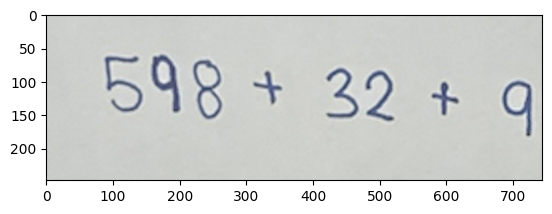

In [498]:
def format(img):
  #resizing so width = 1000, while maintaining aspect ratio
  h, w, c = img.shape
  if (w>1000):
    aspect_ratio = w/h
    w = 1000
    h = int(w/aspect_ratio)
    img = cv2.resize(img, (w, h), interpolation = cv2.INTER_AREA)

  plt.imshow(img) # show image
  plt.show()
  return img

img = cv2.imread('kk.png')
im2 = img.copy()
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # converting image colours open cv format (RGB)
im3 = img.copy()
img = format(img)

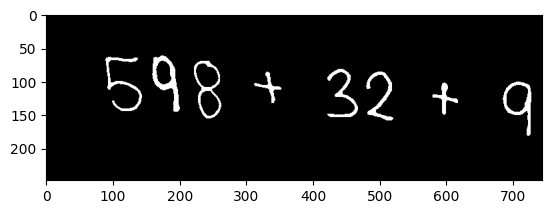

In [499]:
def thresholding(img):
  grey_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  # contrast: pixel intensity > 80 threshold = 255 (max value)
  # inverting: THRESH_BINARY_INV = max values --> 0, all other values --> 255
  ret, thresh = cv2.threshold(grey_img,130,255,cv2.THRESH_BINARY_INV) #high contrast, then inverting image
  plt.imshow(thresh, cmap='gray')
  return thresh

thresh_img = thresholding(img)

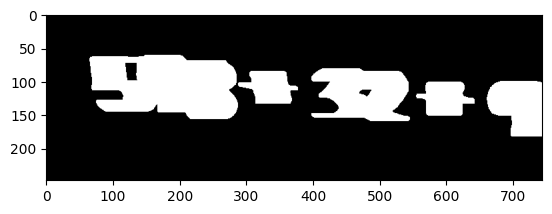

In [500]:
# detecting lines
kernel = np.ones((3,50), np.uint8) # kernel of size 3x85 to detect high intensity of surrounding pixels around selected pixel (blank space)
dilated = cv2.dilate(thresh_img, kernel, iterations = 1)  # finds regions of low intensity & sets all pixels in kernel to low intensity (boxy regions)
plt.imshow(dilated, cmap='gray')

In [501]:
# detects contours
# RETR_EXTERNAL: contour retrieval method (finds outermost contours)
# HAIN_APPROX_NONE: contour approximation method (all points = used for exact shape rather than approximation of shape)
(contours, hierarchy) = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
contour_nums = sorted(contours, key = lambda ctr: cv2.boundingRect(ctr)[0]) # array of contour lines sorted lowest to highest y-value (top->bottom)

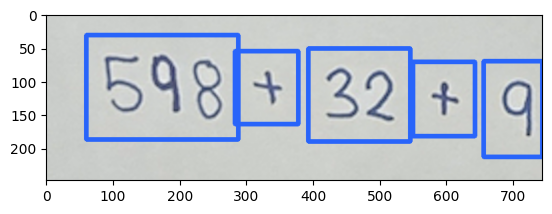

In [502]:
img2 = img.copy()
terms = []

# uses coordinates in contour_lines to draw bounding rectangles
for ctr in contour_nums:
  x, y, w, h = cv2.boundingRect(ctr)
  if(w*h>400):
    cv2.rectangle(img2, (x-5, y-30), (x+w, y+h+30), (40, 100, 250), 5) # (image,top-left corner, bottom-right corner, blue, thickness)
    terms.append([x-5, y-30, x+w, y+h+30])

plt.imshow(img2)

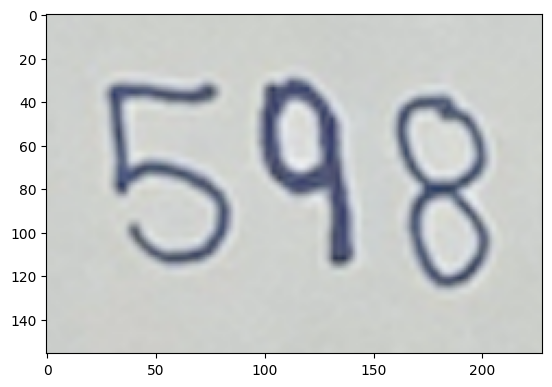

In [503]:
first_term = terms[0]
# [0] = xmin, [1] = ymin, [2] = xmax, [3] = ymax
first_term_roi = img[first_term[1]:first_term[3], first_term[0]:first_term[2]]
img2 = format(first_term_roi)

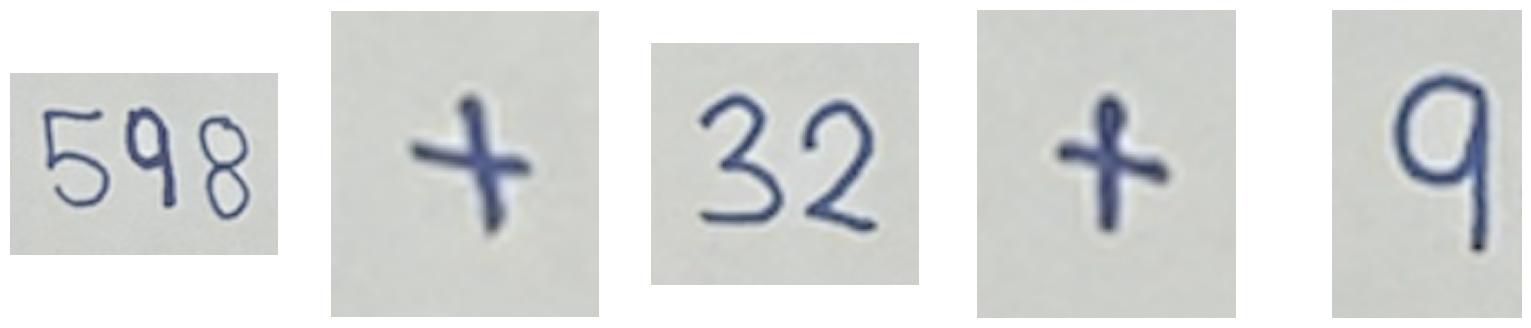

In [504]:
# grid
num_cols = len(terms)
fig, axes = plt.subplots(1, num_cols, figsize=(num_cols * 4, 4))

term_roi = []
for i in range(len(terms)):
    image = img[terms[i][1]:terms[i][3], terms[i][0]:terms[i][2]]
    term_roi.append(image)
    axes[i].imshow(image, cmap='gray')
    axes[i].axis('off')

plt.show()

## Segmenting  numbers into digits:

In [505]:
def thresholding_digit(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(img,150,255,cv2.THRESH_BINARY_INV)
    return thresh

term_thresh = []
for i in range(len(term_roi)):
  term_thresh.append(thresholding_digit(term_roi[i]))


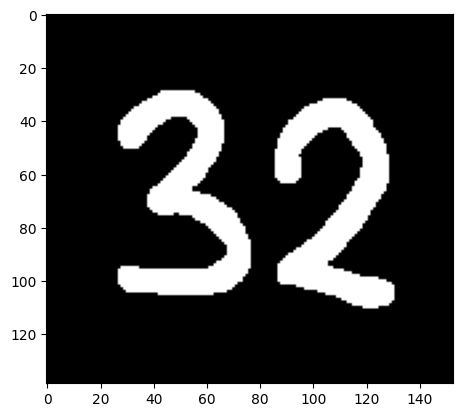

In [506]:
#dilation
kernel = np.ones((5,4), np.uint8)
term_dilated = []
for i in range(len(term_thresh)):
  term_dilated.append(cv2.dilate(term_thresh[i], kernel, iterations = 1))

plt.imshow(term_dilated[2], cmap='gray')

In [507]:
expression = []
expression_images = []

for i in range(len(term_roi)):
    # Find contours within this region (i.e., digits within the term)
    cnt2, hierarchy2 = cv2.findContours(term_dilated[i].copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contour_digs = sorted(cnt2, key=lambda cntr: cv2.boundingRect(cntr)[0])
    digits = []
    digit_images = []
    for ctr in contour_digs:
      x, y, w, h = cv2.boundingRect(ctr)
      digits.append([x, y, w, h])
      pt1 = (terms[i][0] + x, terms[i][1] + y)
      pt2 = (terms[i][0] + x + w, terms[i][1] + y + h)
      digit_images.append(im3[terms[i][1] + y:terms[i][1] + y + h, terms[i][0] + x:terms[i][0] + x + w])
      cv2.rectangle(im2, pt1, pt2, (255, 255, 100), 2)
    expression.append(digits)
    expression_images.append(digit_images)

print(expression)


[[[28, 31, 58, 86], [98, 28, 45, 90], [160, 36, 46, 92]], [[28, 29, 44, 52]], [[27, 29, 50, 77], [86, 32, 45, 79]], [[28, 29, 43, 53]], [[28, 28, 46, 86]]]


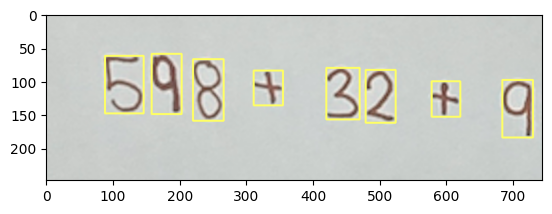

In [508]:
plt.imshow(im2)

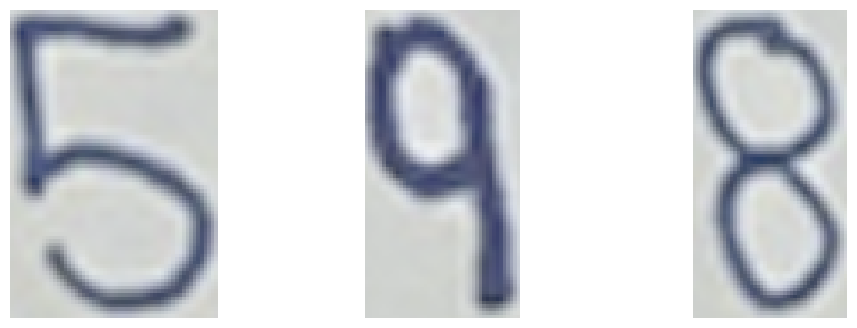

In [509]:
# grid
num_cols = len(expression[0])
fig, axes = plt.subplots(1, num_cols, figsize=(num_cols * 4, 4))

term_roi = []
for i in range(len(expression[0])):
    axes[i].imshow(expression_images[0][i], cmap='gray')
    axes[i].axis('off')

plt.show()

## Digit detection neural network:

In [525]:
import tensorflow as tf
import numpy as np
import zipfile
import os
from PIL import Image

# Define function to extract images from the zip file
def extract_images(zip_file_path, extract_to):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        for file_info in zip_ref.infolist():
            # Skip extraction of directories and files starting with '__MACOSX'
            if not file_info.filename.startswith('__MACOSX'):
                zip_ref.extract(file_info, extract_to)

# Extract images from the zip file, skipping '__MACOSX' directory
extract_images('symbols.zip', 'symbols')

# Define function to load images and labels from directory
def load_data(directory):
    images = []
    labels = []
    label_mapping = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9,
                     'slash': 10, 'minus': 11, 'dot': 12, 'plus': 13, 'w': 14, 'x': 15, 'y': 16, 'z': 17}
    for root, dirs, files in os.walk(directory):
        for image_file in files:
            if not image_file.startswith('__MACOSX') and not image_file.startswith('._'):
                image_path = os.path.join(root, image_file)
                # Attempt to open the image file
                try:
                    img = Image.open(image_path).convert('L')  # Convert to grayscale
                    img = img.resize((28, 28))
                    img = np.array(img) / 255.0  # Normalize
                    images.append(img)
                    # Extract label from the filename
                    label_str = image_file.split('-')[0]  # Get the label part from the filename
                    label = label_mapping.get(label_str, None)  # Map labels to IDs
                    if label is not None:
                        labels.append(label)
                    else:
                        print(f"Skipping image file '{image_path}' due to invalid label: {label_str}")
                except Exception as e:
                    print(f"Error loading image file '{image_path}': {e}")
    return np.array(images), np.array(labels)

# Load data
x_train, y_train = load_data('symbols')

# Shuffle the data if needed
indices = np.arange(len(x_train))
np.random.shuffle(indices)
x_train = x_train[indices]
y_train = y_train[indices]

# Split data into tr†aining and testing sets
split_ratio = 0.8  # 80% training, 20% testing
split_index = int(len(x_train) * split_ratio)
x_train, x_test = x_train[:split_index], x_train[split_index:]
y_train, y_test = y_train[:split_index], y_train[split_index:]

# Define and compile your model
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28)), # input layer
    tf.keras.layers.Dense(128, activation='relu'), # hidden layer
    tf.keras.layers.Dense(128, activation='relu'), # hidden layer
    tf.keras.layers.Dense(128, activation='relu'), # hidden layer
    tf.keras.layers.Dense(18, activation='softmax') # output layer (18 classes, including letters and symbols)
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=3)

# Save the model
model.save('handwritten_model.h5')

# Load the model
loaded_model = tf.keras.models.load_model('handwritten_model.h5')

# Evaluate the model
loss, accuracy = loaded_model.evaluate(x_test, y_test)


Epoch 1/3
675/675 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5352 - loss: 1.5253
Epoch 2/3
675/675 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8545 - loss: 0.4885
Epoch 3/3
675/675 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8801 - loss: 0.3865


169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8651 - loss: 0.4227


In [526]:
def convert(num):
  if np.all(num == 10):
      return 'slash'
  elif np.all(num == 11):
      return '-'
  elif np.all(num == 12):
      return '0'
  elif np.all(num == 13):
      return '+'
  elif np.all(num == 14):
      return '4'
  elif np.all(num == 15):
      return '+'
  elif np.all(num == 16):
      return 'y'
  elif np.all(num == 17):
      return '2'
  else:
      return str(num)

Actual Digit 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Predicted Digit: 1


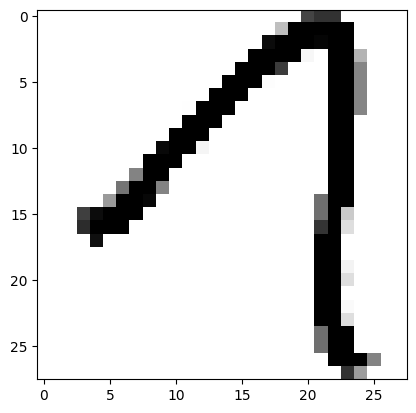

In [527]:
plt.imshow(x_test[191], cmap='gray')
print("Actual Digit", convert(y_test[191]))

prediction = model.predict(np.array([x_test[191]]))
print("Predicted Digit:", convert(np.argmax(prediction)))



In [564]:
def resize_image(image):
  # resize, grayscale, contrast, invert
  h, w = image.shape[:2]
  new_height = int(min(28, h/w*40))
  image = cv2.resize(image, (28, new_height)) # 18
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  return image


def adjust_img(image):

  # testing
  h, w = image.shape

  # Iterate through all pixels and adjust their intensity
  for y in range(h):
      for x in range(w):
          intensity = image[y, x]
          new_intensity = min(255, max(0, intensity * 0.05 - 6.5))
          if new_intensity > 2:
            image[y, x] = 255  # White
          else:
            image[y, x] = new_intensity


          # image[y, x] = new_intensity

  # background
  background = np.ones((28, 28), dtype=np.uint8)
  background +=2

  y_offset = (28 - h) // 2
  x_offset = (28 - w) // 2
  background[y_offset:y_offset+h, x_offset:x_offset+w] = image


  return background


def img_to_int(img):
    img = resize_image(img)
    img = adjust_img(img)

    # Prediction
    prediction = model.predict(np.array([img]))
    return convert(np.argmax(prediction))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
8


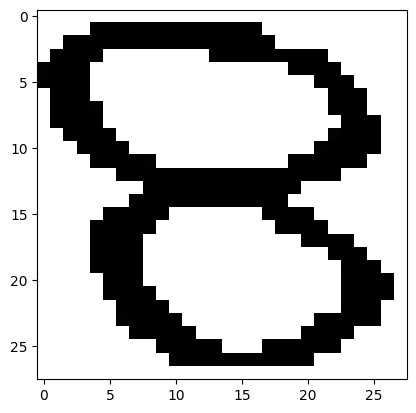

In [565]:
img = adjust_img(resize_image(expression_images[0][2]))
plt.imshow(img, cmap='gray')
print(img_to_int(expression_images[0][2]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
+
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
+
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
9


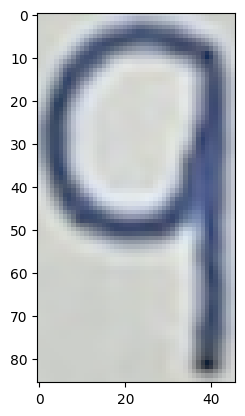

In [567]:

numerical_expression = []


for i in range(len(expression)):
  numerical_term = []
  for j in range(len(expression[i])):
    dig = img_to_int(expression_images[i][j])
    numerical_term.append(dig)
    plt.imshow(expression_images[i][j])
    print(dig)
  numerical_expression.append(numerical_term)


## Transforming predictions into numbers:

In [568]:
equation = ''
for i in range(len(numerical_expression)):
  for j in range(len(numerical_expression[i])):
    if numerical_expression[i][j] == 'plus':
      equation += '+'
    elif numerical_expression[i][j] == 'minus':
      equation += '-'
    elif numerical_expression[i][j] == 'dot':
      equation += '-'
    elif numerical_expression[i][j] == 'slash':
      equation += '/'
    elif numerical_expression[i][j] == 'w':
      equation += 'w'
    elif numerical_expression[i][j] == 'x':
      equation += '+'
    elif numerical_expression[i][j] == 'y':
      equation += '4'
    elif numerical_expression[i][j] == 'z':
      equation += 'z'
    else:
      equation += str(numerical_expression[i][j])
  equation += ' '

print(equation)
result = eval(equation)
print('=', result)


598 + 32 + 9 
= 639
